# v2 - TAP Model
- Date: 31/01/2023
- Based on: Zsolts serpent model (in TAPreactor folder)

Questions:
1. S(a,b) for moderator? (Zr, and for H)
1. C0 instead of C12 in moderator?

In [11]:
FAST_REACTOR = True # True if epithermal, False if thermal

# Fuel properties
FUEL_TEMP = 900 # K
# FUEL_ENRICHMENT = 4.0 # wo% # NOT NEEDED IN THIS MODEL
# FUEL_R = 5 # cm # NOT NEEDED IN THIS MODEL

# Moderator properties
MODERATOR_TEMP = 900 # K
MODERATOR_R = 1.15 # cm

# Cladding properties
CLADDING_TEMP = 900 # K
CLADDING_R = 1.25 # cm

# Lattice properties
LATTICE_ELEMENTS_INNER = 7
LATTICE_PITCH_INNER = 3 # cm

LATTICE_ELEMENTS_OUTER = 20 # Amount of elements per side
LATTICE_PITCH_OUTER = 15 # cm

# Containment properties
CONTAINMENT_R = 150 # cm
CONTAINMENT_THICKNESS = 25 # cm -> total 175 cm radius, -> 350 cm diameter

# Core properties
CORE_HEIGHT = 300 # cm

In [12]:
import openmc
import numpy as np
import matplotlib.pyplot as plt
import os

# @@@@@@@@@@@@@@@@@@@@@@ Materials @@@@@@@@@@@@@@@@@@@@@@
# Fuel
material_fuel = openmc.Material(1, "ULiF", temperature=FUEL_TEMP)
material_fuel.add_nuclide('U235', 3.11e-2, 'wo')
material_fuel.add_nuclide('U238', 5.909e-1, 'wo')
material_fuel.add_nuclide('Li7', 4.8358e-2, 'wo')
material_fuel.add_nuclide('Li6', 2.418e-6, 'wo')
material_fuel.add_nuclide('F19', 3.2964e-1, 'wo')
material_fuel.set_density('g/cm3', 5.01)

# Cladding
material_cladding = openmc.Material(2, "ZrH", temperature=CLADDING_TEMP)
material_cladding.add_nuclide('Zr90', 4.9793e-1, 'wo')
material_cladding.add_nuclide('Zr91', 1.0980e-1, 'wo')
material_cladding.add_nuclide('Zr92', 1.6967e-1, 'wo')
material_cladding.add_nuclide('Zr94', 1.7569e-1, 'wo')
material_cladding.add_nuclide('Zr96', 2.8908e-2, 'wo')
material_cladding.add_nuclide('H1', 1.8007e-2, 'wo')
material_cladding.add_nuclide('H2', 4.1389e-6, 'wo')
material_cladding.set_density('g/cm3', 5.66)

# Moderator
material_moderator = openmc.Material(3, "CSi", temperature=MODERATOR_TEMP)
material_moderator.add_nuclide('C0', 2.9936e-1, 'wo')
material_moderator.add_nuclide('Si28', 6.4365e-1, 'wo')
material_moderator.add_nuclide('Si29', 3.3866e-2, 'wo')
material_moderator.add_nuclide('Si30', 2.3120e-2, 'wo')
material_moderator.set_density('g/cm3', 3.21)

# Create Materials list and export to XML
mats = openmc.Materials([material_fuel, material_cladding, material_moderator])
mats.export_to_xml()
# @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@



# @@@@@@@@@@@@@@@@@@@@@@ Geometry @@@@@@@@@@@@@@@@@@@@@@
# Planes
plane_bottom = openmc.ZPlane(z0=-CORE_HEIGHT/2, boundary_type='vacuum')
plane_top = openmc.ZPlane(z0=CORE_HEIGHT/2, boundary_type='vacuum')

# Cylinders
r_moderator = openmc.ZCylinder(r=MODERATOR_R)
r_cladding = openmc.ZCylinder(r=CLADDING_R)

# Regions
region_height_bound = +plane_bottom & -plane_top
region_moderator = -r_moderator & region_height_bound
region_cladding = +r_moderator & -r_cladding & region_height_bound
region_fuel = +r_cladding & region_height_bound

# # Cells
cell_cladding = openmc.Cell(name="cladding", fill=material_cladding, region=region_cladding)
cell_moderator = openmc.Cell(name="moderator", fill=material_moderator, region=region_moderator)
cell_fuel = openmc.Cell(name="fuel", fill=material_fuel, region=region_fuel)

# # Universe
universe_pin = openmc.Universe(cells=(cell_cladding, cell_moderator, cell_fuel))

# # Outer universe
cell_all_fuel = openmc.Cell(name="outer", fill=material_fuel)
universe_outer = openmc.Universe(cells=(cell_all_fuel,))
# @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@



# @@@@@@@@@@@@@@@@@@@@@@ Lattice @@@@@@@@@@@@@@@@@@@@@@
# Inner lattice
innerLatticeDistanceToCenter = LATTICE_PITCH_INNER * LATTICE_ELEMENTS_INNER / 2
lattice_inner = openmc.RectLattice()
lattice_inner.lower_left = (-innerLatticeDistanceToCenter, -innerLatticeDistanceToCenter) # TODO: Is this needed?
# lattice_inner.lower_left = (0, 0)
lattice_inner.pitch = (LATTICE_PITCH_INNER, LATTICE_PITCH_INNER)

if not FAST_REACTOR:
    def get_universe_pin(x_idx, y_idx):
        if 1 <= x_idx <= LATTICE_ELEMENTS_INNER - 2 and 1 <= y_idx <= LATTICE_ELEMENTS_INNER - 2:
            return universe_pin
        return universe_outer
else:
    # Make sure LATTICE_ELEMENTS_INNER is odd
    if LATTICE_ELEMENTS_INNER % 2 == 0: raise Exception("LATTICE_ELEMENTS_INNER must be odd if FAST_REACTOR is False")
    def get_universe_pin(x_idx, y_idx):
        corner1 = x_idx == LATTICE_ELEMENTS_INNER // 2 - 1 and y_idx == LATTICE_ELEMENTS_INNER // 2 - 1
        corner2 = x_idx == LATTICE_ELEMENTS_INNER // 2 + 1 and y_idx == LATTICE_ELEMENTS_INNER // 2 - 1
        corner3 = x_idx == LATTICE_ELEMENTS_INNER // 2 - 1 and y_idx == LATTICE_ELEMENTS_INNER // 2 + 1
        corner4 = x_idx == LATTICE_ELEMENTS_INNER // 2 + 1 and y_idx == LATTICE_ELEMENTS_INNER // 2 + 1
        if corner1 or corner2 or corner3 or corner4:
            return universe_pin
        return universe_outer
    
lattice_inner.universes = [[get_universe_pin(x_idx, y_idx) for x_idx in range(LATTICE_ELEMENTS_INNER)] for y_idx in range(LATTICE_ELEMENTS_INNER)]

# Make a universe out of the inner lattice
cell_lattice_inner = openmc.Cell(name="lattice_inner", fill=lattice_inner)
universe_lattice_inner = openmc.Universe(cells=(cell_lattice_inner,))

# Outer lattice
outerLatticeDistanceToCenter = LATTICE_PITCH_OUTER * LATTICE_ELEMENTS_OUTER / 2
lattice_outer = openmc.RectLattice()
lattice_outer.lower_left = (-outerLatticeDistanceToCenter, -outerLatticeDistanceToCenter) # TODO: Is this needed?
# lattice_outer.lower_left = (0, 0)
lattice_outer.pitch = (LATTICE_PITCH_OUTER, LATTICE_PITCH_OUTER)

# get_lattice_inner returns universe_lattice_inner if A1, and universe_outer if F, in the following scheme:
# F F  F  F  F  F  F  F  F  F  F  F  F  F  F  F  F  F  F  F 
# F F  F  F  F  F  A1 A1 A1 A1 A1 A1 A1 A1 F  F  F  F  F  F
# F F  F  F  F  A1 A1 A1 A1 A1 A1 A1 A1 A1 A1 F  F  F  F  F
# F F  F  A1 A1 A1 A1 A1 A1 A1 A1 A1 A1 A1 A1 A1 A1 F  F  F
# F F  F  A1 A1 A1 A1 A1 A1 A1 A1 A1 A1 A1 A1 A1 A1 F  F  F
# F F  A1 A1 A1 A1 A1 A1 A1 A1 A1 A1 A1 A1 A1 A1 A1 A1 F  F
# F A1 A1 A1 A1 A1 A1 A1 A1 A1 A1 A1 A1 A1 A1 A1 A1 A1 A1 F
# F A1 A1 A1 A1 A1 A1 A1 A1 A1 A1 A1 A1 A1 A1 A1 A1 A1 A1 F
# F A1 A1 A1 A1 A1 A1 A1 A1 A1 A1 A1 A1 A1 A1 A1 A1 A1 A1 F
# F A1 A1 A1 A1 A1 A1 A1 A1 A1 A1 A1 A1 A1 A1 A1 A1 A1 A1 F
# F A1 A1 A1 A1 A1 A1 A1 A1 A1 A1 A1 A1 A1 A1 A1 A1 A1 A1 F
# F A1 A1 A1 A1 A1 A1 A1 A1 A1 A1 A1 A1 A1 A1 A1 A1 A1 A1 F
# F A1 A1 A1 A1 A1 A1 A1 A1 A1 A1 A1 A1 A1 A1 A1 A1 A1 A1 F
# F A1 A1 A1 A1 A1 A1 A1 A1 A1 A1 A1 A1 A1 A1 A1 A1 A1 A1 F
# F F  A1 A1 A1 A1 A1 A1 A1 A1 A1 A1 A1 A1 A1 A1 A1 A1 F  F
# F F  F  A1 A1 A1 A1 A1 A1 A1 A1 A1 A1 A1 A1 A1 A1 F  F  F
# F F  F  A1 A1 A1 A1 A1 A1 A1 A1 A1 A1 A1 A1 A1 A1 F  F  F
# F F  F  F  F  A1 A1 A1 A1 A1 A1 A1 A1 A1 A1 F  F  F  F  F
# F F  F  F  F  F  A1 A1 A1 A1 A1 A1 A1 A1 F  F  F  F  F  F
# F F  F  F  F  F  F  F  F  F  F  F  F  F  F  F  F  F  F  F

def symmetrize(idx, idx_to_query):
    if idx == idx_to_query or idx == LATTICE_ELEMENTS_OUTER - idx_to_query - 1:
        return True
    return False

def get_boundaries(idx): 
    if symmetrize(idx, 0):
        return 9, 10
    if symmetrize(idx, 1):
        return 5, 14
    if symmetrize(idx, 2):
        return 4, 15
    if symmetrize(idx, 3):
        return 2, 17
    if symmetrize(idx, 4):
        return 2, 17
    if symmetrize(idx, 5):
        return 1, 18
    if symmetrize(idx, 6):
        return 0, 19    
    if symmetrize(idx, 7):
        return 0, 19
    if symmetrize(idx, 8):
        return 0, 19
    if symmetrize(idx, 9):
        return 0, 19

def get_lattice_inner(x_idx, y_idx):
    if LATTICE_ELEMENTS_OUTER != 20:
        raise Exception("This function is only valid for LATTICE_ELEMENTS_OUTER = 20")
    
        
    x_boundaries = get_boundaries(x_idx)
    y_boundaries = get_boundaries(y_idx)

    # I know the folloing looks weird, as x and y are swapped, but it's correct
    is_inside_x = x_boundaries[0] < y_idx < x_boundaries[1]
    is_inside_y = y_boundaries[0] < x_idx < y_boundaries[1]

    if is_inside_x and is_inside_y:
        return universe_lattice_inner
    
    return universe_outer

lattice_outer.universes = [[get_lattice_inner(x_idx, y_idx) for x_idx in range(LATTICE_ELEMENTS_OUTER)] for y_idx in range(LATTICE_ELEMENTS_OUTER)]

plane_containment_bottom = openmc.ZPlane(z0=-CORE_HEIGHT/2+CONTAINMENT_THICKNESS, boundary_type='vacuum')
plane_containment_top = openmc.ZPlane(z0=CORE_HEIGHT/2-CONTAINMENT_THICKNESS, boundary_type='vacuum')
r_containment_inner = openmc.ZCylinder(r=CONTAINMENT_R)
r_containment_outer = openmc.ZCylinder(r=CONTAINMENT_R+CONTAINMENT_THICKNESS, boundary_type='vacuum')

bottom_slab = +plane_bottom & -plane_containment_bottom
top_slab = -plane_top & +plane_containment_top
region_height_bound_inner = +plane_containment_bottom & -plane_containment_top
region_containment = (+r_containment_inner & -r_containment_outer & region_height_bound) | (-r_containment_inner & (bottom_slab | top_slab))

cell_containment = openmc.Cell(name="containment", fill=material_cladding, region=region_containment)
cell_main = openmc.Cell(fill=lattice_outer, region=(-r_containment_inner & region_height_bound_inner))
geometry = openmc.Geometry([cell_containment, cell_main])
geometry.export_to_xml()
# @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@

/Users/sigge/opt/anaconda3/lib/python3.9/site-packages/openmc/mixin.py:70: IDWarning: Another Material instance already exists with id=1.
  warn(msg, IDWarning)
/Users/sigge/opt/anaconda3/lib/python3.9/site-packages/openmc/mixin.py:70: IDWarning: Another Material instance already exists with id=2.
  warn(msg, IDWarning)
/Users/sigge/opt/anaconda3/lib/python3.9/site-packages/openmc/mixin.py:70: IDWarning: Another Material instance already exists with id=3.
  warn(msg, IDWarning)


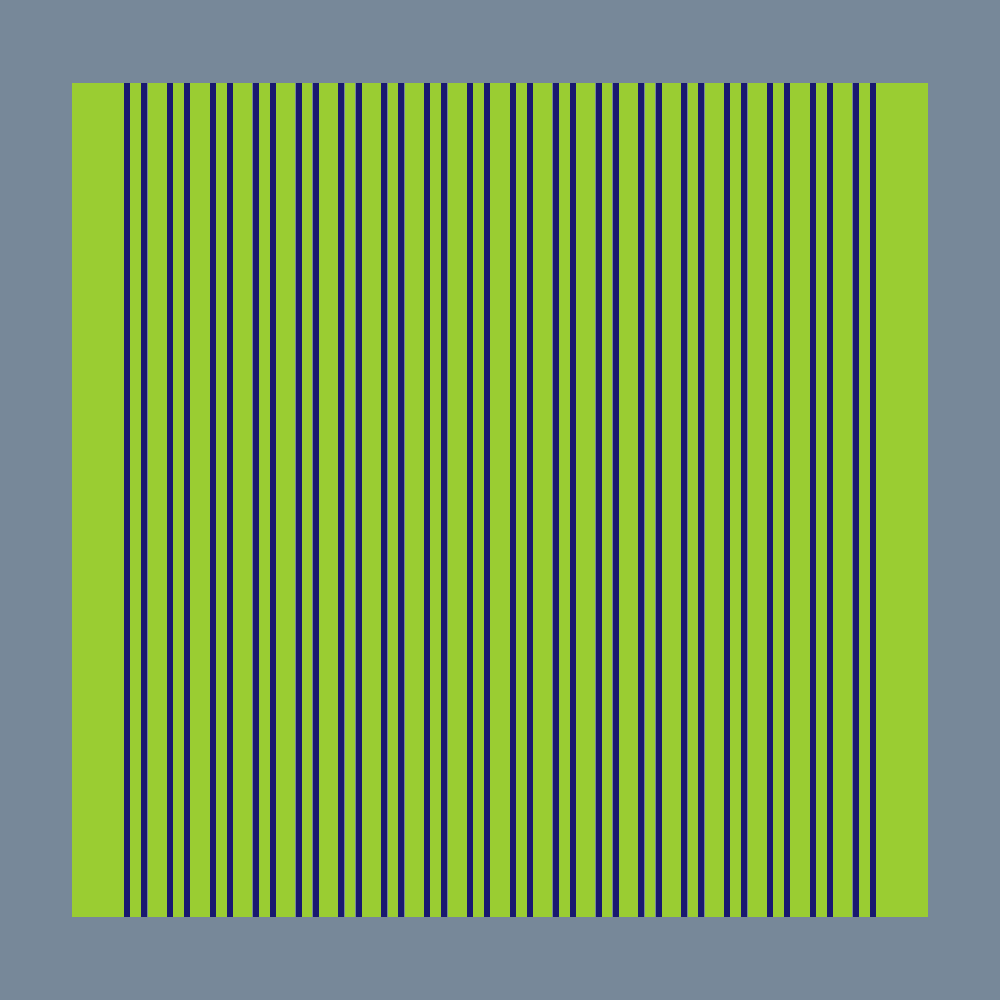

In [13]:
# @@@@@@@@@@@@@@@@@@@@@@ Plots @@@@@@@@@@@@@@@@@@@@@@

PLOT_COLOR_BY = 'material'
PLOT_PIXELS = (1000, 1000)
PLOT_FUEL_COLOR = 'yellowgreen'
PLOT_CLADDING_COLOR = 'lightslategray'
PLOT_MODERATOR_COLOR = 'midnightblue'


colors = {
    material_fuel: PLOT_FUEL_COLOR,
    material_cladding: PLOT_CLADDING_COLOR,
    material_moderator: PLOT_MODERATOR_COLOR
}

plotXY = openmc.Plot.from_geometry(geometry, basis='xy')
plotXY.color_by = PLOT_COLOR_BY
plotXY.filename = f'plotXY-FAST_REACTOR={FAST_REACTOR}'
plotXY.pixels = PLOT_PIXELS
plotXY.colors = colors
plotXY.to_ipython_image()

# Add slice_coord to actually see the moderator rods in the plot
plotXZ = openmc.Plot.from_geometry(geometry, basis='xz', slice_coord=4)
plotXZ.color_by = PLOT_COLOR_BY
plotXZ.filename = f'plotXZ-FAST_REACTOR={FAST_REACTOR}'
plotXZ.pixels = PLOT_PIXELS
plotXZ.colors = colors
plotXZ.to_ipython_image()


# plots = openmc.Plots([plot])
# plots.export_to_xml()
# set xlabel of plot

# vox_plot = openmc.Plot()
# vox_plot.type = 'voxel'
# vox_plot.width = (100., 100., 50.)
# vox_plot.pixels = (400, 400, 200)
# vox_plot.to_ipython_image()
# @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
